In [ ]:
#importing libraries
import segyio
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [ ]:
#contracting block of unet
class ContractingBlock(nn.Module):
    def __init__(self, input_channels):
        super(ContractingBlock, self).__init__()
        
        # Wou want to double the number of channels in the first convolution
        # and keep the same number of channels in the second.
        
        self.conv1 = nn.Conv2d(input_channels, 2*input_channels, kernel_size=3, padding=(1,1))
        self.conv2 = nn.Conv2d(2*input_channels, 2*input_channels, kernel_size=3, padding=(1,1))
        self.activation = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
       

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

In [ ]:
# unit test
def test_contracting_block(test_samples = 1, test_channels=1, test_size=254):
    test_block = ContractingBlock(test_channels)
    test_in = torch.randn(test_samples, test_channels, test_size, test_size)
    test_out_conv1 = test_block.conv1(test_in)
    
    print(test_out_conv1.shape)

In [ ]:
test_contracting_block(128)
# 1, 512, 60, 60

torch.Size([128, 2, 254, 254])


In [ ]:
#expanding block of unet
class ExpandingBlock(nn.Module):

    def __init__(self, input_channels):
        super(ExpandingBlock, self).__init__()
        
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)      
        self.conv1 = nn.Conv2d(input_channels, input_channels//2, kernel_size=3, padding=(1,1))
        self.conv2 = nn.Conv2d(input_channels, input_channels//2, kernel_size=3, padding=(1,1))
        self.conv3 = nn.Conv2d(input_channels//2, input_channels//2, kernel_size=3, padding=(1,1))
        
        self.activation = nn.ReLU() # "each followed by a ReLU"
 
    def forward(self, x, skip_con_x):

        x = self.upsample(x)
        x = self.conv1(x)        
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        return x

In [ ]:
#UNIT TEST
def test_expanding_block(test_samples=1, test_channels=64*16, test_size=32):
    test_block = ExpandingBlock(test_channels)
    skip_con_x = torch.randn(test_samples, test_channels // 2, test_size * 2 + 6, test_size * 2 + 6)
    x = torch.randn(test_samples, test_channels, test_size, test_size)
    x = test_block.upsample(x)

    print(x.shape)

test_expanding_block()

torch.Size([1, 1024, 64, 64])


In [ ]:
#maps to final output required dimension by 1x1 convolution
class FeatureMapBlock(nn.Module):

    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)
        

    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
#combined unet model
class UNet(nn.Module):

    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(UNet, self).__init__()        
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.expand1 = ExpandingBlock(hidden_channels * 16)
        self.expand2 = ExpandingBlock(hidden_channels * 8)
        self.expand3 = ExpandingBlock(hidden_channels * 4)
        self.expand4 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        
    def forward(self, x):

        # Keep in mind that the expand function takes two inputs, 
        # both with the same number of channels.                 
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)        
        x2 = self.contract2(x1)        
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        
        x5 = self.expand1(x4, x3)
        x6 = self.expand2(x5, x2)
        x7 = self.expand3(x6, x1)
        x8 = self.expand4(x7, x0)
        xn = self.downfeature(x8)          
        return xn

In [ ]:
# unit test
test_unet = UNet(1,1)
# print(test_unet(torch.randn(1, 1, 256, 256)).shape)
print(test_unet(torch.randn(1, 1, 512, 512)).shape)

torch.Size([1, 1, 512, 512])


In [ ]:
filename_pp = "C:/Users/Rohit K Rajgarhia/Documents/sociology of eco. dev/Equinor synthetic model/Export_5/issap20_Pp.sgy"
filename_ai = "C:/Users/Rohit K Rajgarhia/Documents/sociology of eco. dev/Equinor synthetic model/Export_5/issap20_AI.sgy"
filename_fault = "C:/Users/Rohit K Rajgarhia/Documents/sociology of eco. dev/Equinor synthetic model/Export_5/issap20_Fault.sgy"

In [ ]:
#convert sgy code to numpy array
def segy2numpy(filename: str) -> np.array:
    with segyio.open(filename, xline=181) as segyfile:
        return segyio.tools.cube(segyfile)

seismic = segy2numpy(filename_pp)
ai = segy2numpy(filename_ai)
fault = segy2numpy(filename_fault)
f"Number of inlines: {seismic.shape[0]}, crosslines: {seismic.shape[1]}, samples: {seismic.shape[2]}"

'Number of inlines: 101, crosslines: 589, samples: 751'

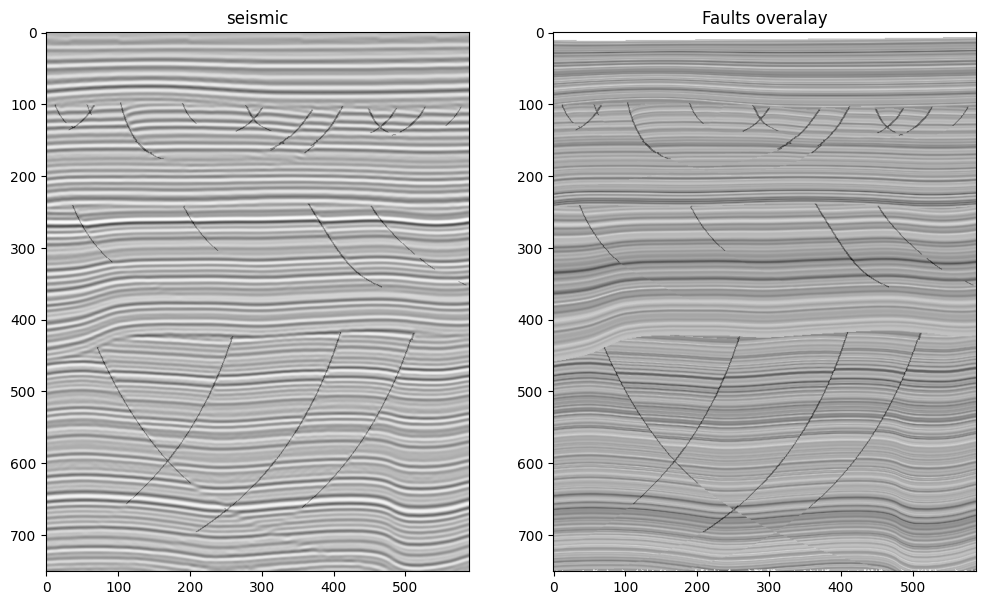

In [ ]:
# plot 
ILINE=10
plt.figure(figsize=(12, 10))
title = ['seismic', 'Faults overalay']
cmaps = ["seismic", None]

for i, cube in enumerate([seismic, ai]):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(cube[ILINE,:, :].T, cmap="Greys")
    plt.imshow(fault[ILINE,:, :].T, cmap='Greys',  vmin=0, vmax=1, alpha=0.3)
    plt.axis()
plt.show()

In [ ]:
#function to show seismic, fault and predicted image during training
def crop_input(image, new_shape):

    
    h, w = image.shape[0], image.shape[1]   # values inside the brackets depends on the input shapes
    new_h, new_w = new_shape[0], new_shape[1]
    
    start_h = int((h - new_h + 1)/2)
    start_w = int((w - new_w + 1)/2)
    
    cropped_image = image[start_h:start_h + new_h, start_w:start_w + new_w] 
    
    return cropped_image

# Function to pad 
import torch.nn.functional as F

def pad_to(image, new_shape):

    h, w = image.shape[0], image.shape[1]
    new_h, new_w = new_shape[0], new_shape[1]
    
    inc_h, inc_w = new_h -h, new_w - w
    left, right = 0, inc_w
    top, bottom = 0, inc_h
    pads = left, right, top, bottom 
    
    padded_image = F.pad(image, pads, "constant", 0)

    return padded_image

In [ ]:
#converting inputs to tensors
new_shape = (512, 512)
image_list = []
fault_list = []
for i in range(101):
    images = torch.from_numpy(seismic[i])
    image_list.append(crop_input(images, new_shape ).unsqueeze(0))
    
    faults = torch.from_numpy(fault[i])
    fault_list.append(crop_input(faults, new_shape).unsqueeze(0))

In [ ]:
image_list[0].shape

torch.Size([1, 512, 512])

In [ ]:
# Loading data into Pytorch Dataset Utitlity
volumes = torch.stack(image_list)
labels = torch.stack(fault_list)
dataset = torch.utils.data.TensorDataset(volumes, labels)

In [ ]:
volumes.shape, labels.shape

(torch.Size([101, 1, 512, 512]), torch.Size([101, 1, 512, 512]))

C:\Users\Rohit K Rajgarhia\AppData\Local\Temp\ipykernel_5764\1976699852.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3281.)
  plt.imshow(volumes[0].T, cmap="gray");


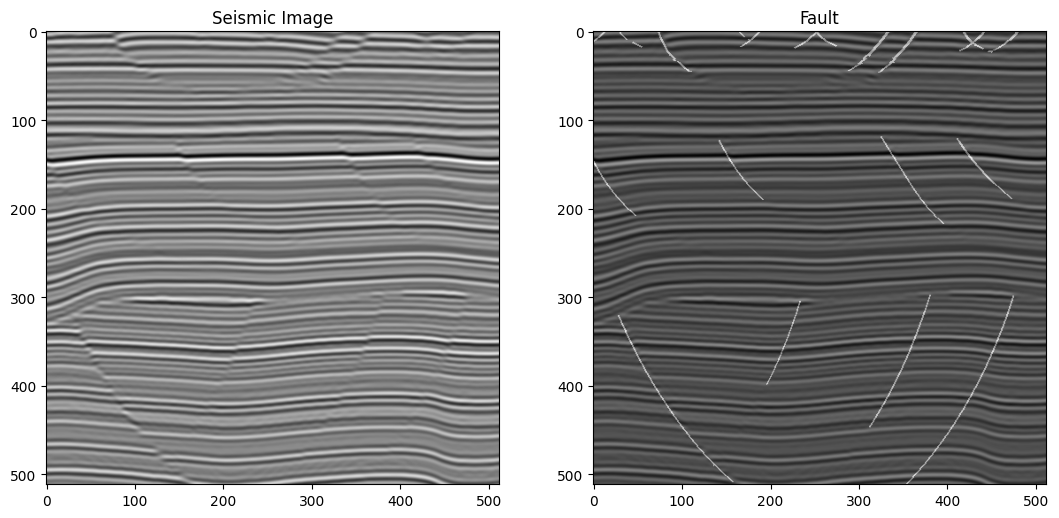

In [ ]:
#Last plot check before training
fig = plt.figure(figsize=(20,20))
    
ax = fig.add_subplot(331)    
plt.imshow(volumes[0].T, cmap="gray");
ax.set_title("Seismic Image")
    
ax = fig.add_subplot(332)
ax.imshow(volumes[0].T, cmap = 'gray')
ax.imshow(labels[0].T, cmap = 'gray', vmin=0, vmax=1, alpha=0.4)
ax.set_title("Fault")
plt.show();

In [ ]:
np.where(volumes[0]==1)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [ ]:


def show_tensor_images(image, fault, pred, num_images=25, size=(1, 28, 28)):

    # image_shifted = (image_tensor + 1) / 2
    #image_shifted = image_tensor
    
    image_unflat = image.detach().cpu()
    fault_unflat = fault.detach().cpu()
    pred_unflat = pred.detach().cpu()
    
    
    fig = plt.figure(figsize=(12,15))
    
    ax = fig.add_subplot(331)    
    ax.imshow(image_unflat.squeeze(), cmap = 'gray')
    ax.set_title("Seismic Image")
    
    ax = fig.add_subplot(332)
    ax.imshow(image_unflat.squeeze(), cmap = 'gray')
    ax.imshow(fault_unflat.squeeze(), cmap = 'gray', vmin=0, vmax=1, alpha=0.4)
    ax.set_title("Fault")
    
    ax = fig.add_subplot(333)
    ax.imshow(image_unflat.squeeze(), cmap = 'gray')
    ax.imshow(pred_unflat.squeeze(), cmap = 'gray', vmin=0, vmax=1, alpha=0.4)
    ax.set_title("Predicted Fault")
    
    plt.show()

In [ ]:
device = torch.device("cpu:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cpu


In [ ]:
np.array(dataset).shape

C:\Users\Rohit K Rajgarhia\AppData\Local\Temp\ipykernel_5764\1704588510.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.array(dataset).shape
C:\Users\Rohit K Rajgarhia\AppData\Local\Temp\ipykernel_5764\1704588510.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(dataset).shape


(101, 2)

In [ ]:
dataset1=dataset[4][0]

In [ ]:
np.array(dataset1).shape

(1, 512, 512)

In [ ]:
# Hyperparameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 1   
input_dim = 1
label_dim = 1
display_step = 500
batch_size = 1
lr = 0.0002
initial_shape = 512
target_shape = 512
device = 'cuda'

In [ ]:
l=[]
def train():
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True)
    print(dataloader)
    unet = UNet(input_dim, label_dim).to(device)
    unet_opt = torch.optim.Adam(unet.parameters(), lr=lr)
    cur_step = 0
    s=0
    train_losses = []

    for epoch in range(n_epochs):
        s=s+1
        if(s==5):
            break
                
        for real, labels in tqdm(dataloader):
            cur_batch_size = len(real)
            # Flatten the image
            real = real.to(device)
            labels = labels.to(device)            
                      

            ### Update U-Net ###
            unet_opt.zero_grad()
            pred = unet(real)
            #print(pred.shape)
            unet_loss = criterion(pred, labels)
            print(unet_loss)
            l.append(unet_loss)
            
            unet_loss.backward()
            unet_opt.step()
            

            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: U-Net loss: {unet_loss.item()}")
                #show_tensor_images(
                    #crop(real, torch.Size([len(real), 1, target_shape, target_shape])), 
                    #size=(input_dim, target_shape, target_shape)
                #)
                #show_tensor_images(real.T, size=(input_dim, target_shape, target_shape))                
                #show_tensor_images(labels.T, size=(label_dim, target_shape, target_shape))
                #show_tensor_images(torch.sigmoid(pred).T, size=(label_dim, target_shape, target_shape))
                show_tensor_images(real.T, labels.T, torch.sigmoid(pred).T, size=(input_dim, target_shape, target_shape))
            cur_step += 1
        
        train_losses.append(unet_loss)
        
               
        
    return unet, pred, train_losses

  0%|          | 0/101 [00:00<?, ?it/s]

tensor(0.6502, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Epoch 0: Step 0: U-Net loss: 0.650175154209137


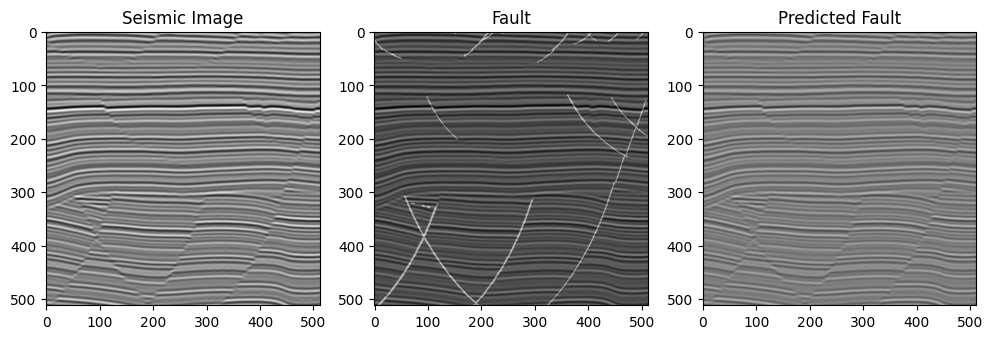

tensor(0.6218, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5946, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5686, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5374, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4897, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3161, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0930, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2328, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0918, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1682, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1794, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1298, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0886, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1321, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1257, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0788, grad_fn=<BinaryCrossEntro

In [ ]:
model, pred, loss = train()

In [ ]:
loss

[tensor(0.0877, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)]

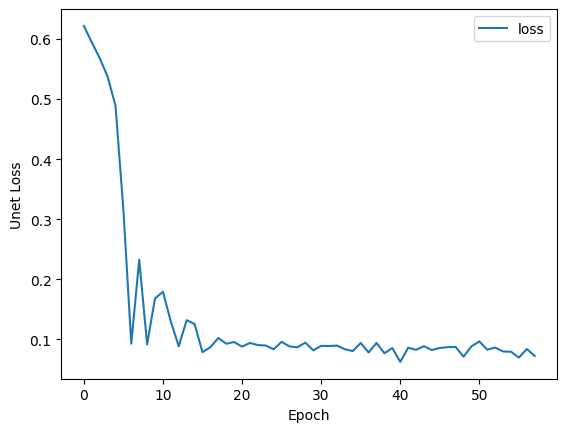

In [ ]:
plt.plot(lis, label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Unet Loss')
plt.legend()
plt.show()

In [ ]:
lis=[0.6218,    
  0.5946,     
  0.5686,    
  0.5374,     
  0.4897,    
  0.3161,     
  0.0930,     
  0.2328,     
  0.0918,     
  0.1682,     
  0.1794,     
  0.1298,     
  0.0886,     
  0.1321,     
  0.1257,     
  0.0788,     
  0.0871,     
  0.1024,     
  0.0929,     
  0.0957,     
  0.0881,     
  0.0942,     
  0.0906,     
  0.0899,     
  0.0836,    
  0.0961,     
  0.0884,     
  0.0870,     
  0.0947,     
  0.0819,     
  0.0893,     
  0.0891,     
  0.0898,     
  0.0837,     
  0.0807,     
  0.0941,     
  0.0784,     
  0.0942,     
  0.0771,     
  0.0857,     
  0.0626,     
  0.0862,     
  0.0828,     
  0.0888,     
  0.0824,     
  0.0858,     
  0.0872,     
  0.0876,     
  0.0713,     
  0.0886,     
  0.0966,     
  0.0830,     
  0.0865,     
  0.0800,     
  0.0795,     
  0.0698,     
  0.0841,     
  0.0726, 
]